In [2]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
import json
from pandas.io.json import json_normalize
!pip install BeautifulSoup4
from bs4 import BeautifulSoup
!pip install geocoder
import geocoder
import os
!pip install folium
import folium # map rendering library
!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

     |████████████████████████████████| 122kB 2.9MB/s eta 0:00:01
     |████████████████████████████████| 102kB 4.9MB/s ta 0:00:011
     |████████████████████████████████| 829kB 8.1MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/d2/3d/fa76db83bf75c4f8d338c2fd15c8d33fdd7ad23a9b5e57eb6c5de26b430e/click-7.1.2-py2.py3-none-any.whl
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
     |████████████████████████████████| 112kB 11.3MB/s eta 0:00:01
Libraries imported.


In [3]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [4]:
def get_venues(lat,lng):
    
    #set variables
    radius=750
    LIMIT=75
    CLIENT_ID = 'NMV0LGXQKQKNT04BNQQK53LZEJWA0OVNB43DT50IJK3QIGQD' # your Foursquare ID
    CLIENT_SECRET = 'NOOSG0IYAU4AJSMCFUD3FYZ2EN3OFDJSVH5PCXJQ4DSS31UU' # your Foursquare Secret
    VERSION = '20201111' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()["response"]['groups'][0]['items']
    venue_details=[]
    for row in results:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df 

In [5]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'NMV0LGXQKQKNT04BNQQK53LZEJWA0OVNB43DT50IJK3QIGQD' # your Foursquare ID
    CLIENT_SECRET = 'NOOSG0IYAU4AJSMCFUD3FYZ2EN3OFDJSVH5PCXJQ4DSS31UU' # your Foursquare Secret
    VERSION = '20201111' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [6]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [7]:
new_york_data=get_new_york_data()

In [8]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [9]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
italian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    italian_resturants=venues[venues['Category']=='Italian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Italian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(italian_resturants)))
    for resturant_detail in italian_resturants.values.tolist():
        id, name , category=resturant_detail
        italian_rest_ny = italian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Italian Restaurants in Wakefield, Bronx:0
( 2 / 306 ) Italian Restaurants in Co-op City, Bronx:0
( 3 / 306 ) Italian Restaurants in Eastchester, Bronx:0
( 4 / 306 ) Italian Restaurants in Fieldston, Bronx:0
( 5 / 306 ) Italian Restaurants in Riverdale, Bronx:1
( 6 / 306 ) Italian Restaurants in Kingsbridge, Bronx:0
( 7 / 306 ) Italian Restaurants in Marble Hill, Manhattan:0
( 8 / 306 ) Italian Restaurants in Woodlawn, Bronx:2
( 9 / 306 ) Italian Restaurants in Norwood, Bronx:0
( 10 / 306 ) Italian Restaurants in Williamsbridge, Bronx:0
( 11 / 306 ) Italian Restaurants in Baychester, Bronx:1
( 12 / 306 ) Italian Restaurants in Pelham Parkway, Bronx:2
( 13 / 306 ) Italian Restaurants in City Island, Bronx:2
( 14 / 306 ) Italian Restaurants in Bedford Park, Bronx:1
( 15 / 306 ) Italian Restaurants in University Heights, Bronx:0
( 16 / 306 ) Italian Restaurants in Morris Heights, Bronx:0
( 17 / 306 ) Italian Restaurants in Fordham, Bronx:0
( 18 / 306 ) Italian Restaurants in Ea

In [10]:
italian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Riverdale,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria
1,Bronx,Woodlawn,511edb6de4b0d58346fd272d,Patrizia's Of Woodlawn
2,Bronx,Woodlawn,4d3cb3026b3d236a066a6364,Rivers Edge
3,Bronx,Baychester,5411894d498e4a254a11a46c,Olive Garden
4,Bronx,Pelham Parkway,4bf96ae65317a593d837017f,Enzo's


In [11]:
italian_rest_ny.shape

(372, 4)

Now lets plot the number of Italian Restaurants for each Borough in New York

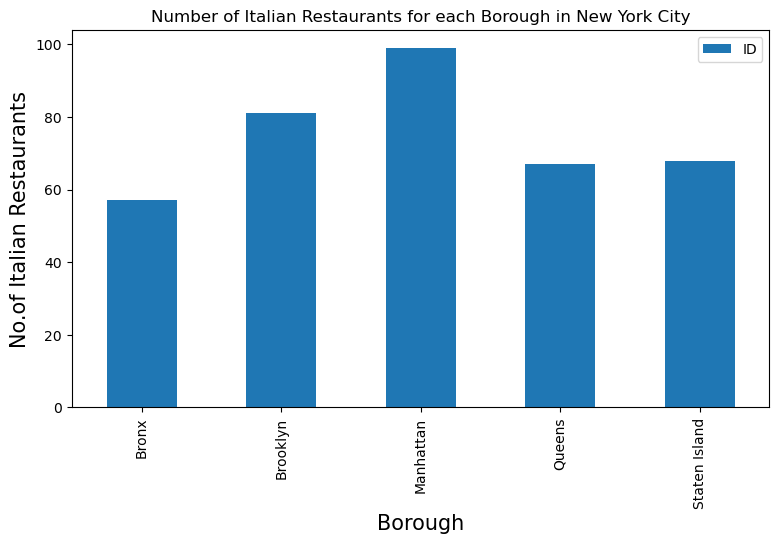

In [12]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Italian Restaurants for each Borough in New York City')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Italian Restaurants', fontsize=15)
italian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
plt.legend()
plt.show()

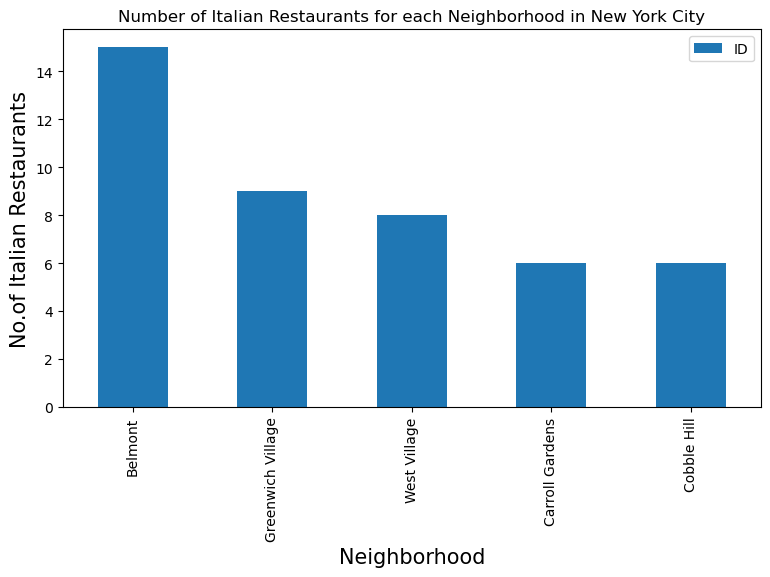

In [13]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Italian Restaurants for each Neighborhood in New York City')
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No.of Italian Restaurants', fontsize=15)
italian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
plt.legend()
plt.show()

In [14]:
italian_rest_ny[italian_rest_ny['Neighborhood']=='Belmont']

,Borough,Neighborhood,ID,Name
22,Bronx,Belmont,4acf80aef964a52025d420e3,Tino's Delicatessen
23,Bronx,Belmont,4bb6470cef159c7465b275f7,Calabria Pork Store
24,Bronx,Belmont,59050f51b23dfa5f6649e678,Arthur Avenue Fiasco
25,Bronx,Belmont,4af0fa29f964a52060e021e3,Antonio's Trattoria
26,Bronx,Belmont,4b5514c4f964a5207cda27e3,Enzo's
27,Bronx,Belmont,4b5a4c8ff964a52049bb28e3,Emilia's Restaurant
28,Bronx,Belmont,4af71916f964a520cf0522e3,Michaelangelo's Coal Fired Brick Oven Pizza Re...
29,Bronx,Belmont,4aa425bef964a5208e4520e3,Dominick's Restaurant
30,Bronx,Belmont,4c79d294278eb713f6a05580,Cafe al Mercato
31,Bronx,Belmont,4a8e261cf964a5201c1220e3,Roberto's


In [15]:
# prepare neighborhood list that contains italian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
italian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in italian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(italian_rest_ny),')','processed')
    italian_rest_stats_ny = italian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID                  Name  Likes  Rating  Tips
0  55aaee4d498e3cbb70e625d6  Bella Notte Pizzeria      9     6.8     4
( 1 / 372 ) processed
                         ID                    Name  Likes  Rating  Tips
0  511edb6de4b0d58346fd272d  Patrizia's Of Woodlawn     18     8.4    14
( 2 / 372 ) processed
                         ID         Name  Likes  Rating  Tips
0  4d3cb3026b3d236a066a6364  Rivers Edge     10     6.3     8
( 3 / 372 ) processed
                         ID          Name  Likes  Rating  Tips
0  5411894d498e4a254a11a46c  Olive Garden     26     7.5     8
( 4 / 372 ) processed
                         ID    Name  Likes  Rating  Tips
0  4bf96ae65317a593d837017f  Enzo's     26     8.6    11
( 5 / 372 ) processed
                         ID         Name  Likes  Rating  Tips
0  4b47f069f964a5208c4426e3  Pasta Pasta      9     6.3     8
( 6 / 372 ) processed
                         ID                       Name  Likes  Rating  Tips
0  4514ed4df964a

In [16]:
italian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Riverdale,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria,9,6.8,4
1,Bronx,Woodlawn,511edb6de4b0d58346fd272d,Patrizia's Of Woodlawn,18,8.4,14
2,Bronx,Woodlawn,4d3cb3026b3d236a066a6364,Rivers Edge,10,6.3,8
3,Bronx,Baychester,5411894d498e4a254a11a46c,Olive Garden,26,7.5,8
4,Bronx,Pelham Parkway,4bf96ae65317a593d837017f,Enzo's,26,8.6,11


In [17]:
italian_rest_stats_ny.shape

(372, 7)

In [18]:
italian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372 entries, 0 to 371
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       372 non-null    object 
 1   Neighborhood  372 non-null    object 
 2   ID            372 non-null    object 
 3   Name          372 non-null    object 
 4   Likes         372 non-null    object 
 5   Rating        372 non-null    float64
 6   Tips          372 non-null    object 
dtypes: float64(1), object(6)
memory usage: 20.5+ KB


In [19]:
italian_rest_stats_ny['Likes']=italian_rest_stats_ny['Likes'].astype('float64')
italian_rest_stats_ny['Tips']=italian_rest_stats_ny['Tips'].astype('float64')

In [20]:
italian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372 entries, 0 to 371
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       372 non-null    object 
 1   Neighborhood  372 non-null    object 
 2   ID            372 non-null    object 
 3   Name          372 non-null    object 
 4   Likes         372 non-null    float64
 5   Rating        372 non-null    float64
 6   Tips          372 non-null    float64
dtypes: float64(3), object(4)
memory usage: 20.5+ KB


In [21]:
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                        Soho
ID              4cc6222106c25481d7a4a047
Name                 Rubirosa Ristorante
Likes                               2496
Rating                               9.3
Tips                                 828
Name: 183, dtype: object

In [22]:
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood                 Fort Greene
ID              5a00f3538496ca58fd9e2856
Name                  Evelina Restaurant
Likes                                200
Rating                               9.4
Tips                                  35
Name: 96, dtype: object

In [23]:
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Tips'].idxmax()]

Borough                    Staten Island
Neighborhood               West Brighton
ID              4b5b58dbf964a52088f628e3
Name                        Panini Grill
Likes                                 22
Rating                               8.5
Tips                                1136
Name: 262, dtype: object

In [24]:
ny_neighborhood_stats=italian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [25]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
22,Bushwick,9.300000
42,Downtown,9.200000
18,Boerum Hill,9.200000
131,Sunnyside Gardens,9.100000
67,Hamilton Heights,9.100000
130,Sunnyside,9.100000
138,Tribeca,9.000000
53,Fort Greene,8.960000
66,Greenwich Village,8.922222
73,Jackson Heights,8.900000


In [26]:
ny_borough_stats=italian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [27]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.515152
1,Brooklyn,8.085185
3,Queens,7.437313
0,Bronx,7.245614
4,Staten Island,5.889706


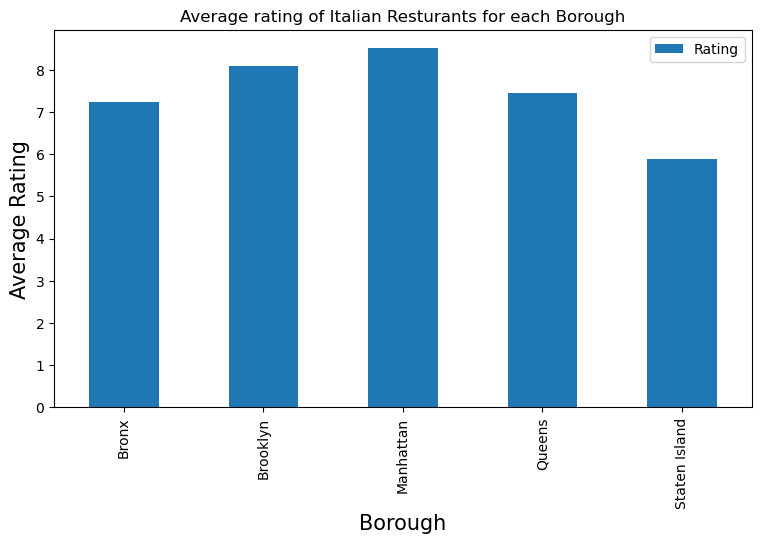

In [28]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Italian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
italian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [29]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]

In [30]:
ny_neighborhood_stats

,Neighborhood,Average Rating
18,Boerum Hill,9.2
22,Bushwick,9.3
42,Downtown,9.2
67,Hamilton Heights,9.1
130,Sunnyside,9.1
131,Sunnyside Gardens,9.1
138,Tribeca,9.0


In [31]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [32]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [33]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Boerum Hill,40.685683,-73.983748,9.2
1,Brooklyn,Bushwick,40.698116,-73.925258,9.3
2,Brooklyn,Downtown,40.690844,-73.983463,9.2
3,Manhattan,Hamilton Heights,40.823604,-73.949688,9.1
4,Queens,Sunnyside,40.740176,-73.926916,9.1
5,Staten Island,Sunnyside,40.612760,-74.097126,9.1
6,Queens,Sunnyside Gardens,40.745652,-73.918193,9.1
7,Manhattan,Tribeca,40.721522,-74.010683,9.0


In [34]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [35]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the neighborhood and add each to the feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [36]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [37]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)